In [16]:
import pandas as pd
import numpy as np
from loaders import *
import math
import random
from attn_masked import parse_timeloop_stats, aggregate_timeloop_runs
import os
import json
import matplotlib.pyplot as plt
folder = "data"

In [86]:
matrix_size = 2048 # CHANGE

dataflow_permuations = [['M', 'N', 'K'], ['M', 'K', 'N'], ['N', 'K', 'M'], ['N', 'M', 'K'], ['K', 'N', 'M'], ['K', 'M', 'N']]
'''
6 different dataflow permutations
9 components for dataflow
= 6^9 = 10077696 possible combinations
'''
# generate all the data flow permuations
def get_dataflow_permutations():
    dataflow_perumations = []
    
    for DRAM in dataflow_permuations:
        for ClusterArray in dataflow_permuations:
            for GLB_Cluster in dataflow_permuations:
                for glb in dataflow_permuations:
                    for PE_Cluster in dataflow_permuations:
                        for iact_spad in dataflow_permuations:
                            for weight_spad in dataflow_permuations:
                                for psum in dataflow_permuations:
                                    for reg in dataflow_permuations:
                                        permutation = {
                                            "DRAM": DRAM,
                                            "ClusterArray": ClusterArray,
                                            # "GLB_Cluster": GLB_Cluster,
                                            # "glb": glb,
                                            "PE_Cluster": PE_Cluster,
                                            "iact_spad": iact_spad,
                                            "weight_spad": weight_spad,
                                            "psum": psum,
                                            "reg": reg,
                                        }
                                        dataflow_perumations.append(permutation)
    return dataflow_perumations

# generate all the possible factor permutations for a specific rank (ie, M, N, or K)
def get_factor_permutations():
    factor_permutations = []
    iact_spad_depth = 16 # M, K
    weight_spad_depth = 192 # K, N
    psum_spad_depth = 32 # M, N

    max_K = int(max(math.log2(weight_spad_depth), math.log2(iact_spad_depth)))
    max_M = int(max(math.log2(psum_spad_depth), math.log2(iact_spad_depth)))
    max_N = int(max(math.log2(weight_spad_depth), math.log2(psum_spad_depth)))     
    
    for DRAM_M in [2**i for i in range(int(math.log2(matrix_size)) + 1)]:
        for DRAM_N in [2**i for i in range(int(math.log2(matrix_size)) + 1)]:
                for DRAM_K in [2**i for i in range(int(math.log2(matrix_size)) + 1)]:

                    for iact_spad_M in [2**i for i in range(max_M + 1)]:
                        for iact_spad_K in [2**j for j in range(max_K + 1)]:
                            iact_spad_N = 1  # Inputs → M & K only
                    
                            for weight_spad_K in [2**i for i in range(max_K + 1)]:
                                for weight_spad_N in [2**j for j in range(max_N + 1)]:
                                    weight_spad_M = 1  # Weights → K & N only
                    
                                    for psum_M in [2**i for i in range(max_M + 1)]:
                                        for psum_N in [2**j for j in range(max_N + 1)]:
                                            psum_K = 1  # Outputs → M & N only
                                            # tile size must fit into the iact_spad, weight_spad, and psum_spad
                                            if not (
                                                ((iact_spad_M * weight_spad_M * psum_M) * (iact_spad_K * weight_spad_K * psum_K) <=  iact_spad_depth) and
                                                ((iact_spad_K * weight_spad_K * psum_K) * (iact_spad_N * weight_spad_N * psum_N) <=  weight_spad_depth) and
                                                ((iact_spad_M * weight_spad_M * psum_M) * (iact_spad_N * weight_spad_N * psum_N) <=  psum_spad_depth)
                                            ):
                                                break

                                            if ((DRAM_M * iact_spad_M * weight_spad_M * psum_M == matrix_size) and
                                                (DRAM_N * iact_spad_N * weight_spad_N * psum_N == matrix_size) and
                                                (DRAM_K * iact_spad_K * weight_spad_K * psum_K == matrix_size)):
                                                permuation = {
                                                    "DRAM_M": DRAM_M,
                                                    "DRAM_N": DRAM_N,
                                                    "DRAM_K": DRAM_K,

                                                    "ClusterArray_M": 1,
                                                    "ClusterArray_N": 1,
                                                    "ClusterArray_K": 1,

                                                    # "GLB_Cluster_M": 1,
                                                    # "GLB_Cluster_N": 1,
                                                    # "GLB_Cluster_K": 1,

                                                    # "glb_M": 4,
                                                    # "glb_N": 4,
                                                    # "glb_K": 4,

                                                    "PE_Cluster_M": 1,
                                                    "PE_Cluster_N": 1,
                                                    "PE_Cluster_K": 1,

                                                    "iact_spad_M": iact_spad_M,
                                                    "iact_spad_N": iact_spad_N,
                                                    "iact_spad_K": iact_spad_K,

                                                    "weight_spad_M": weight_spad_M,
                                                    "weight_spad_N": weight_spad_N,
                                                    "weight_spad_K": weight_spad_K,

                                                    "psum_M": psum_M,
                                                    "psum_N": psum_N,
                                                    "psum_K": psum_K,

                                                    "reg_M": 1,
                                                    "reg_N": 1,
                                                    "reg_K": 1,
                                                }
                                                factor_permutations.append(permuation) 
    return factor_permutations

def update_factor_permutation_helper(factor_permutation, component, max_spatial, factor):
    # factor is M, N, or K
    # component is PE_Cluster or ClusterArray
    factor_permutation[f"{component}_{factor}"] = max_spatial
    for component in ["DRAM", "iact_spad", "weight_spad", "psum", "reg"]:
        curr_component_factor = factor_permutation[f"{component}_{factor}"]
        if curr_component_factor >= max_spatial:
            factor_permutation[f"{component}_{factor}"] = curr_component_factor // max_spatial
            break
    
def update_factor_permutation(factor_permutation, dataflow_permutation):
    # Cluster Array is 8x2
    # PE_Cluster is 4x4
    possible_max_ClusterArray = [(8, 2)]
    possible_max_PE_Cluster = [(4, 4)]
    max_ClusterArray = random.choice(possible_max_ClusterArray)
    max_PE_Cluster = random.choice(possible_max_PE_Cluster)
    
    max_ClusterArray_X = max_ClusterArray[0]
    max_ClusterArray_Y = max_ClusterArray[1]
    max_PE_Cluster_X = max_PE_Cluster[1]
    max_PE_Cluster_Y = max_PE_Cluster[1]
    
    
    PE_Cluster_dataflow = dataflow_permutation["PE_Cluster"]
    PE_Cluster_dataflow_X = PE_Cluster_dataflow[0]
    PE_Cluster_dataflow_Y = PE_Cluster_dataflow[1]

    update_factor_permutation_helper(factor_permutation, "PE_Cluster", max_PE_Cluster_X, PE_Cluster_dataflow_X)
    update_factor_permutation_helper(factor_permutation, "PE_Cluster", max_PE_Cluster_Y, PE_Cluster_dataflow_Y)

    ClusterArray_dataflow = dataflow_permutation["ClusterArray"]
    ClusterArray_dataflow_X = ClusterArray_dataflow[0]
    ClusterArray_dataflow_Y = ClusterArray_dataflow[1]

    update_factor_permutation_helper(factor_permutation, "ClusterArray", max_ClusterArray_X, ClusterArray_dataflow_X)
    update_factor_permutation_helper(factor_permutation, "ClusterArray", max_ClusterArray_Y, ClusterArray_dataflow_Y)
    

In [60]:
dataflow_permutations = get_dataflow_permutations()
factor_permutations = get_factor_permutations()

In [87]:
def hash_config(config):
    return tuple((k, tuple(v) if isinstance(v, list) else v) for k, v in config.items())

def sample_config(dataflow_permutations, factor_permutations):
    factor_permutation = random.choice(factor_permutations)
    dataflow_permutation = random.choice(dataflow_permutations)

    update_factor_permutation(factor_permutation, dataflow_permutation)
    
    config = dict(
        matrix_size_M_dim=matrix_size,
        matrix_size_K_dim=matrix_size,
        matrix_size_N_dim=matrix_size,
        
        DRAM_factor_M=factor_permutation["DRAM_M"],
        DRAM_factor_N=factor_permutation["DRAM_N"],
        DRAM_factor_K=factor_permutation["DRAM_K"],
        DRAM_permutation=dataflow_permutation["DRAM"],
    
        ClusterArray_factor_M=factor_permutation["ClusterArray_M"],
        ClusterArray_factor_N=factor_permutation["ClusterArray_N"],
        ClusterArray_factor_K=factor_permutation["ClusterArray_K"],
        ClusterArray_permutation=dataflow_permutation["ClusterArray"],
    
        # GLB_Cluster_factor_M=factor_permutation["GLB_Cluster_M"],
        # GLB_Cluster_factor_N=factor_permutation["GLB_Cluster_N"],
        # GLB_Cluster_factor_K=factor_permutation["GLB_Cluster_K"],
        # GLB_Cluster_permutation=dataflow_permutation["GLB_Cluster"],
    
        # glb_factor_M=factor_permutation["glb_M"],
        # glb_factor_N=factor_permutation["glb_N"],
        # glb_factor_K=factor_permutation["glb_K"],
        # glb_permutation=dataflow_permutation["glb"],
    
        PE_Cluster_factor_M=factor_permutation["PE_Cluster_M"],
        PE_Cluster_factor_N=factor_permutation["PE_Cluster_N"],
        PE_Cluster_factor_K=factor_permutation["PE_Cluster_K"],
        PE_Cluster_permutation=dataflow_permutation["PE_Cluster"],
    
        iact_spad_factor_M=factor_permutation["iact_spad_M"],
        iact_spad_factor_N=factor_permutation["iact_spad_N"],
        iact_spad_factor_K=factor_permutation["iact_spad_K"],
        iact_spad_permutation=dataflow_permutation["iact_spad"],
    
        weight_spad_factor_M=factor_permutation["weight_spad_M"],
        weight_spad_factor_N=factor_permutation["weight_spad_N"],
        weight_spad_factor_K=factor_permutation["weight_spad_K"],
        weight_spad_permutation=dataflow_permutation["weight_spad"],
    
        psum_factor_M=factor_permutation["psum_M"],
        psum_factor_N=factor_permutation["psum_N"],
        psum_factor_K=factor_permutation["psum_K"],
        psum_permutation=dataflow_permutation["psum"],
    
        reg_factor_M=factor_permutation["reg_M"],
        reg_factor_N=factor_permutation["reg_N"],
        reg_factor_K=factor_permutation["reg_K"],
        reg_permutation=dataflow_permutation["reg"],
    
        density_weights=1,
        density_inputs=1,

        pe_meshX=4,
        pe_meshY=4,
    )
    return config

In [88]:
def evaluate_config(config, sparse_opt=None):
    if sparse_opt == None:
        sparse_opt = 'designs/baseline/baseline_sparse_opt.yaml'

    out = run_timeloop_model(
        config,
        problem='designs/baseline/baseline_problem.yaml',
        mapping='designs/baseline/baseline_mapping.yaml',
        sparse_optimizations=sparse_opt, 
    )
    stats = open('./output_dir/timeloop-model.stats.txt', 'r').read()
    return stats


def update_opt_config_and_curr_opt(config, attributes, opt_config, curr_opt, sparse_opt=None):
    q1_config, q2_config, q4_config = config.copy(), config.copy(), config.copy()
    q1_config['density_inputs'] = 0.5
    q2_config['density_inputs'] = 0.001
    q4_config['density_inputs'] = 1.0

    q1_stats = evaluate_config(q1_config, sparse_opt)
    q2_stats = evaluate_config(q2_config, sparse_opt)
    q4_stats = evaluate_config(q4_config, sparse_opt)
    
    all_stats = [q1_stats, q2_stats, q1_stats, q4_stats]
    
    parsed_runs = [parse_timeloop_stats(stats) for stats in all_stats]
    combined_stats = aggregate_timeloop_runs(parsed_runs)

    for attr in attributes: 
        if attr in ['total_energy_uJ', 'computes_per_cycle']:
            val = combined_stats[attr]
        elif attr == 'utilization_percent': 
            val = combined_stats[attr]['overall']
        elif attr == 'memory_traffic': 
            val = sum(combined_stats[attr].values())
        else: 
            raise ValueError(f"{attr} not a valid attribute.")

        if attr in ['total_energy_uJ', 'memory_traffic']: 
            if val < curr_opt[attr]:
                opt_config[attr] = config
                curr_opt[attr] = val
        elif attr in ['utilization_percent', 'computes_per_cycle']: 
            if val > curr_opt[attr]: 
                opt_config[attr] = config
                curr_opt[attr] = val


def get_initial_opt_config_and_curr_opt(attributes):
    curr_opt = {}
    for attr in attributes: 
        if attr in ['total_energy_uJ', 'memory_traffic']: 
            curr_opt[attr] = float('inf')
        elif attr in ['utilization_percent', 'computes_per_cycle']: 
            curr_opt[attr] = -float('inf')
        else: 
            raise ValueError(f"Unexpected Attribute {attr}")
            
    opt_config =  {attr: None for attr in attributes}
    return opt_config, curr_opt
    

def get_min_config_attention(attributes, num_of_random_samples = 1, default_config=None):
    print(f"optimizing over: {attributes}, num_of_random_samples: {num_of_random_samples}")
    visited = set()
                
    opt_config, curr_opt =  get_initial_opt_config_and_curr_opt(attributes)
    
    # uses random sampling instead of a for loop
    for sample in range(num_of_random_samples):
        # print("\nsample: ", sample, "curr_min", curr_min)
        
        config = sample_config(dataflow_permutations, factor_permutations)
        while hash_config(config) in visited:
            config = sample_config(dataflow_permutations, factor_permutations)
        visited.add(hash_config(config))
        # print("config: ", config)

        update_opt_config_and_curr_opt(config, attributes, opt_config, curr_opt)

    return opt_config, curr_opt

In [99]:
num_of_random_samples = 5
attributes = ['total_energy_uJ', 'utilization_percent', 'computes_per_cycle', 'memory_traffic']
min_config, curr_min = get_min_config_attention(attributes, num_of_random_samples)
print("==================OUTPUT==================")
# print("min_config: ", min_config)
print("curr_min: ", curr_min)

optimizing over: ['total_energy_uJ', 'utilization_percent', 'computes_per_cycle', 'memory_traffic'], num_of_random_samples: 5
before:  {'DRAM_M': 1024, 'DRAM_N': 1024, 'DRAM_K': 512, 'ClusterArray_M': 1, 'ClusterArray_N': 1, 'ClusterArray_K': 1, 'PE_Cluster_M': 1, 'PE_Cluster_N': 1, 'PE_Cluster_K': 1, 'iact_spad_M': 2, 'iact_spad_N': 1, 'iact_spad_K': 4, 'weight_spad_M': 1, 'weight_spad_N': 1, 'weight_spad_K': 1, 'psum_M': 1, 'psum_N': 2, 'psum_K': 1, 'reg_M': 1, 'reg_N': 1, 'reg_K': 1}
component:  PE_Cluster 4 K
before:  1
after:  4
component:  PE_Cluster 4 N
before:  1
after:  4
component:  ClusterArray 8 M
before:  1
after:  8
component:  ClusterArray 2 N
before:  1
after:  2
after:  {'DRAM_M': 128, 'DRAM_N': 128, 'DRAM_K': 128, 'ClusterArray_M': 8, 'ClusterArray_N': 2, 'ClusterArray_K': 1, 'PE_Cluster_M': 1, 'PE_Cluster_N': 4, 'PE_Cluster_K': 4, 'iact_spad_M': 2, 'iact_spad_N': 1, 'iact_spad_K': 4, 'weight_spad_M': 1, 'weight_spad_N': 1, 'weight_spad_K': 1, 'psum_M': 1, 'psum_N': 2

INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 19:31:50,161 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 19:32:01,065 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


before:  {'DRAM_M': 1024, 'DRAM_N': 256, 'DRAM_K': 256, 'ClusterArray_M': 1, 'ClusterArray_N': 1, 'ClusterArray_K': 1, 'PE_Cluster_M': 1, 'PE_Cluster_N': 1, 'PE_Cluster_K': 1, 'iact_spad_M': 1, 'iact_spad_N': 1, 'iact_spad_K': 1, 'weight_spad_M': 1, 'weight_spad_N': 1, 'weight_spad_K': 8, 'psum_M': 2, 'psum_N': 8, 'psum_K': 1, 'reg_M': 1, 'reg_N': 1, 'reg_K': 1}
component:  PE_Cluster 4 K
before:  1
after:  4
component:  PE_Cluster 4 M
before:  1
after:  4
component:  ClusterArray 8 K
before:  1
after:  8
component:  ClusterArray 2 N
before:  1
after:  2
after:  {'DRAM_M': 256, 'DRAM_N': 128, 'DRAM_K': 8, 'ClusterArray_M': 1, 'ClusterArray_N': 2, 'ClusterArray_K': 8, 'PE_Cluster_M': 4, 'PE_Cluster_N': 1, 'PE_Cluster_K': 4, 'iact_spad_M': 1, 'iact_spad_N': 1, 'iact_spad_K': 1, 'weight_spad_M': 1, 'weight_spad_N': 1, 'weight_spad_K': 8, 'psum_M': 2, 'psum_N': 8, 'psum_K': 1, 'reg_M': 1, 'reg_N': 1, 'reg_K': 1}
[INFO] 2025-05-04 19:32:11,829 - pytimeloop.accelergy_interface - Running Acce

INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 19:32:22,093 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 19:32:32,845 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


before:  {'DRAM_M': 512, 'DRAM_N': 256, 'DRAM_K': 1024, 'ClusterArray_M': 1, 'ClusterArray_N': 1, 'ClusterArray_K': 1, 'PE_Cluster_M': 1, 'PE_Cluster_N': 1, 'PE_Cluster_K': 1, 'iact_spad_M': 1, 'iact_spad_N': 1, 'iact_spad_K': 2, 'weight_spad_M': 1, 'weight_spad_N': 4, 'weight_spad_K': 1, 'psum_M': 4, 'psum_N': 2, 'psum_K': 1, 'reg_M': 1, 'reg_N': 1, 'reg_K': 1}
component:  PE_Cluster 4 K
before:  1
after:  4
component:  PE_Cluster 4 N
before:  1
after:  4
component:  ClusterArray 8 M
before:  1
after:  8
component:  ClusterArray 2 N
before:  1
after:  2
after:  {'DRAM_M': 64, 'DRAM_N': 32, 'DRAM_K': 256, 'ClusterArray_M': 8, 'ClusterArray_N': 2, 'ClusterArray_K': 1, 'PE_Cluster_M': 1, 'PE_Cluster_N': 4, 'PE_Cluster_K': 4, 'iact_spad_M': 1, 'iact_spad_N': 1, 'iact_spad_K': 2, 'weight_spad_M': 1, 'weight_spad_N': 4, 'weight_spad_K': 1, 'psum_M': 4, 'psum_N': 2, 'psum_K': 1, 'reg_M': 1, 'reg_N': 1, 'reg_K': 1}
[INFO] 2025-05-04 19:32:44,068 - pytimeloop.accelergy_interface - Running Acce

INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 19:32:55,774 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 19:33:05,985 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


before:  {'DRAM_M': 1024, 'DRAM_N': 512, 'DRAM_K': 256, 'ClusterArray_M': 1, 'ClusterArray_N': 1, 'ClusterArray_K': 1, 'PE_Cluster_M': 1, 'PE_Cluster_N': 1, 'PE_Cluster_K': 1, 'iact_spad_M': 1, 'iact_spad_N': 1, 'iact_spad_K': 4, 'weight_spad_M': 1, 'weight_spad_N': 1, 'weight_spad_K': 2, 'psum_M': 2, 'psum_N': 4, 'psum_K': 1, 'reg_M': 1, 'reg_N': 1, 'reg_K': 1}
component:  PE_Cluster 4 K
before:  1
after:  4
component:  PE_Cluster 4 N
before:  1
after:  4
component:  ClusterArray 8 K
before:  1
after:  8
component:  ClusterArray 2 N
before:  1
after:  2
after:  {'DRAM_M': 1024, 'DRAM_N': 64, 'DRAM_K': 8, 'ClusterArray_M': 1, 'ClusterArray_N': 2, 'ClusterArray_K': 8, 'PE_Cluster_M': 1, 'PE_Cluster_N': 4, 'PE_Cluster_K': 4, 'iact_spad_M': 1, 'iact_spad_N': 1, 'iact_spad_K': 4, 'weight_spad_M': 1, 'weight_spad_N': 1, 'weight_spad_K': 2, 'psum_M': 2, 'psum_N': 4, 'psum_K': 1, 'reg_M': 1, 'reg_N': 1, 'reg_K': 1}
[INFO] 2025-05-04 19:33:16,537 - pytimeloop.accelergy_interface - Running Acce

INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 19:33:27,370 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 19:33:38,454 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


before:  {'DRAM_M': 2048, 'DRAM_N': 128, 'DRAM_K': 256, 'ClusterArray_M': 1, 'ClusterArray_N': 1, 'ClusterArray_K': 1, 'PE_Cluster_M': 1, 'PE_Cluster_N': 1, 'PE_Cluster_K': 1, 'iact_spad_M': 1, 'iact_spad_N': 1, 'iact_spad_K': 1, 'weight_spad_M': 1, 'weight_spad_N': 1, 'weight_spad_K': 8, 'psum_M': 1, 'psum_N': 16, 'psum_K': 1, 'reg_M': 1, 'reg_N': 1, 'reg_K': 1}
component:  PE_Cluster 4 K
before:  1
after:  4
component:  PE_Cluster 4 N
before:  1
after:  4
component:  ClusterArray 8 N
before:  1
after:  8
component:  ClusterArray 2 M
before:  1
after:  2
after:  {'DRAM_M': 1024, 'DRAM_N': 4, 'DRAM_K': 64, 'ClusterArray_M': 2, 'ClusterArray_N': 8, 'ClusterArray_K': 1, 'PE_Cluster_M': 1, 'PE_Cluster_N': 4, 'PE_Cluster_K': 4, 'iact_spad_M': 1, 'iact_spad_N': 1, 'iact_spad_K': 1, 'weight_spad_M': 1, 'weight_spad_N': 1, 'weight_spad_K': 8, 'psum_M': 1, 'psum_N': 16, 'psum_K': 1, 'reg_M': 1, 'reg_N': 1, 'reg_K': 1}
[INFO] 2025-05-04 19:33:51,701 - pytimeloop.accelergy_interface - Running Ac

INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 19:34:02,574 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 19:34:13,320 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


==================OUTPUT==================
curr_min:  {'total_energy_uJ': 373679.97, 'utilization_percent': 100.0, 'computes_per_cycle': 255.99999784041145, 'memory_traffic': 134597295734}


In [96]:
# !timeloop model ./output_dir/parsed-processed-input.yaml

Running apps: model
Found parsed-processed-input.yaml in input files. Running Timeloop without parsing or processing steps. If this is not the intended behavior, please name the input files differently.
input file: /home/workspace/final_project/output_dir/parsed-processed-input.yaml
execute:/usr/local/bin/accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml --oprefix timeloop-model. -o ./ > timeloop-model.accelergy.log 2>&1
Start Parsering Layout
No Layout specified, so using bandwidth based modeling
ERROR: couldn't map level DRAM: more compression ranks needed than supported in hardware. dataspace name: Inputs


In [15]:
# name = "bello" #Change
# os.makedirs(f"{folder}", exist_ok=True)

# with open(f"{folder}/250_min_config_{name}", "w") as f:
#     json.dump(min_config, f, indent=2)
# with open(f"{folder}/250_curr_min_{name}", "w") as f:
#     json.dump(curr_min, f, indent=2)

In [13]:
# Change the number of PE's and keep the config the same
default_config = {
    "matrix_size_M_dim": 2048,
    "matrix_size_K_dim": 2048,
    "matrix_size_N_dim": 2048,
    "DRAM_factor_M": 2048,
    "DRAM_factor_N": 256,
    "DRAM_factor_K": 128,
    "DRAM_permutation": [
      "M",
      "K",
      "N"
    ],
    "ClusterArray_factor_M": 1,
    "ClusterArray_factor_N": 1,
    "ClusterArray_factor_K": 1,
    "ClusterArray_permutation": [
      "K",
      "M",
      "N"
    ],
    "PE_Cluster_factor_M": 1,
    "PE_Cluster_factor_N": 1,
    "PE_Cluster_factor_K": 1,
    "PE_Cluster_permutation": [
      "M",
      "N",
      "K"
    ],
    "iact_spad_factor_M": 1,
    "iact_spad_factor_N": 1,
    "iact_spad_factor_K": 1,
    "iact_spad_permutation": [
      "K",
      "N",
      "M"
    ],
    "weight_spad_factor_M": 1,
    "weight_spad_factor_N": 4,
    "weight_spad_factor_K": 16,
    "weight_spad_permutation": [
      "K",
      "M",
      "N"
    ],
    "psum_factor_M": 1,
    "psum_factor_N": 2,
    "psum_factor_K": 1,
    "psum_permutation": [
      "N",
      "K",
      "M"
    ],
    "reg_factor_M": 1,
    "reg_factor_N": 1,
    "reg_factor_K": 1,
    "reg_permutation": [
      "K",
      "N",
      "M"
    ],
    "density_weights": 1,
    "density_inputs": 1,
    "pe_meshX": 4,
    "pe_meshY": 4
}

In [51]:
# # Change the number of PE's and keep the config the same
# def get_pe_experiment_data(config, attributes, min_pe=1, max_pe=1):
#     min_pe = 1
#     pe_data = {}
#     for pe_X in range(min_pe, max_pe + 1):
#         for pe_Y in range(min_pe, max_pe + 1):
#             config['pe_meshX'] = pe_X
#             config['pe_meshY'] = pe_Y
    
#             opt_config, curr_opt =  get_initial_opt_config_and_curr_opt(attributes)
#             update_opt_config_and_curr_opt(config, attributes, opt_config, curr_opt)
#             pe_data[(pe_X, pe_Y)] = curr_opt
#     return pe_data

# attributes = ['total_energy_uJ', 'utilization_percent', 'computes_per_cycle', 'memory_traffic']
# pe_data = get_pe_experiment_data(default_config, attributes, max_pe=10)

# serializable_data = {f"{k[0]},{k[1]}": v for k, v in pe_data.items()}

# with open(f"{folder}/pe_experiment_data.json", "w") as f:
#     json.dump(serializable_data, f, indent=4)

[INFO] 2025-05-04 18:31:28,214 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 18:31:39,201 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 18:31:49,713 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 18:32:00,548 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 18:32:11,206 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 18:32:21,707 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 18:32:32,235 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


KeyboardInterrupt: 

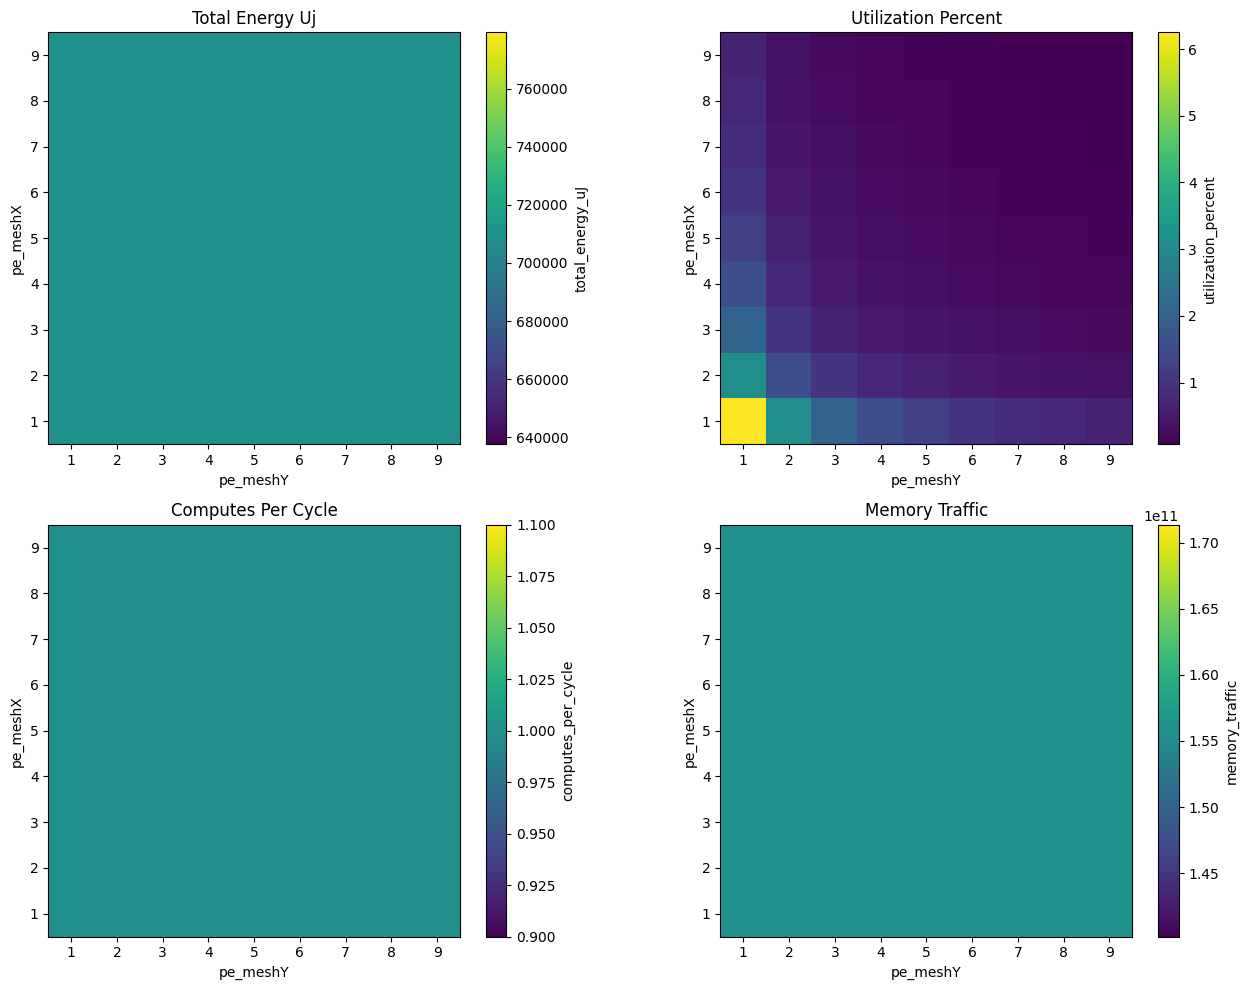

In [17]:
with open(f"{folder}/pe_experiment_data.json", "r") as f:
    loaded_data = json.load(f)
pe_data = {tuple(map(int, k.split(','))): v for k, v in loaded_data.items()}

max_pe = 10
min_pe = 1

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, attr in enumerate(attributes):
    heatmap = np.zeros((max_pe - min_pe, max_pe - min_pe))
    
    for x in range(min_pe, max_pe):
        for y in range(min_pe, max_pe):
            heatmap[x - min_pe, y - min_pe] = pe_data[(x, y)][attr]
    
    im = axs[i].imshow(heatmap, origin='lower', cmap='viridis')
    axs[i].set_title(attr.replace('_', ' ').title())
    axs[i].set_xlabel('pe_meshY')
    axs[i].set_ylabel('pe_meshX')
    axs[i].set_xticks(np.arange(max_pe - min_pe))
    axs[i].set_yticks(np.arange(max_pe - min_pe))
    axs[i].set_xticklabels(range(min_pe, max_pe))
    axs[i].set_yticklabels(range(min_pe, max_pe))
    
    cbar = plt.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)
    cbar.set_label(attr)

plt.tight_layout()
plt.show()

In [48]:
# change the sparsity
def get_CSR_vs_COO(config, attributes):
    sparse_opt_dict = {}
    for sparse_repr  in ["COO", "CSR"]:
        sparse_opt = f"designs/attention/{sparse_repr}.yaml"
        opt_config, curr_opt =  get_initial_opt_config_and_curr_opt(attributes)
        update_opt_config_and_curr_opt(config, attributes, opt_config, curr_opt, sparse_opt)
        sparse_opt_dict[sparse_repr] = curr_opt
    return sparse_opt_dict

attributes = ['total_energy_uJ', 'utilization_percent', 'computes_per_cycle', 'memory_traffic']
sparse_opt_dict = get_CSR_vs_COO(default_config, attributes)
# print("sparse_opt_dict: ", sparse_opt_dict)

with open(f"{folder}/sparse_opt_data.json", "w") as f:
    json.dump(sparse_opt_dict, f, indent=4)

[INFO] 2025-05-04 07:07:30,012 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 07:07:40,660 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 07:07:51,461 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 07:08:02,548 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 07:08:13,395 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 07:08:24,396 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


In [49]:
# !timeloop model ./output_dir/parsed-processed-input.yaml

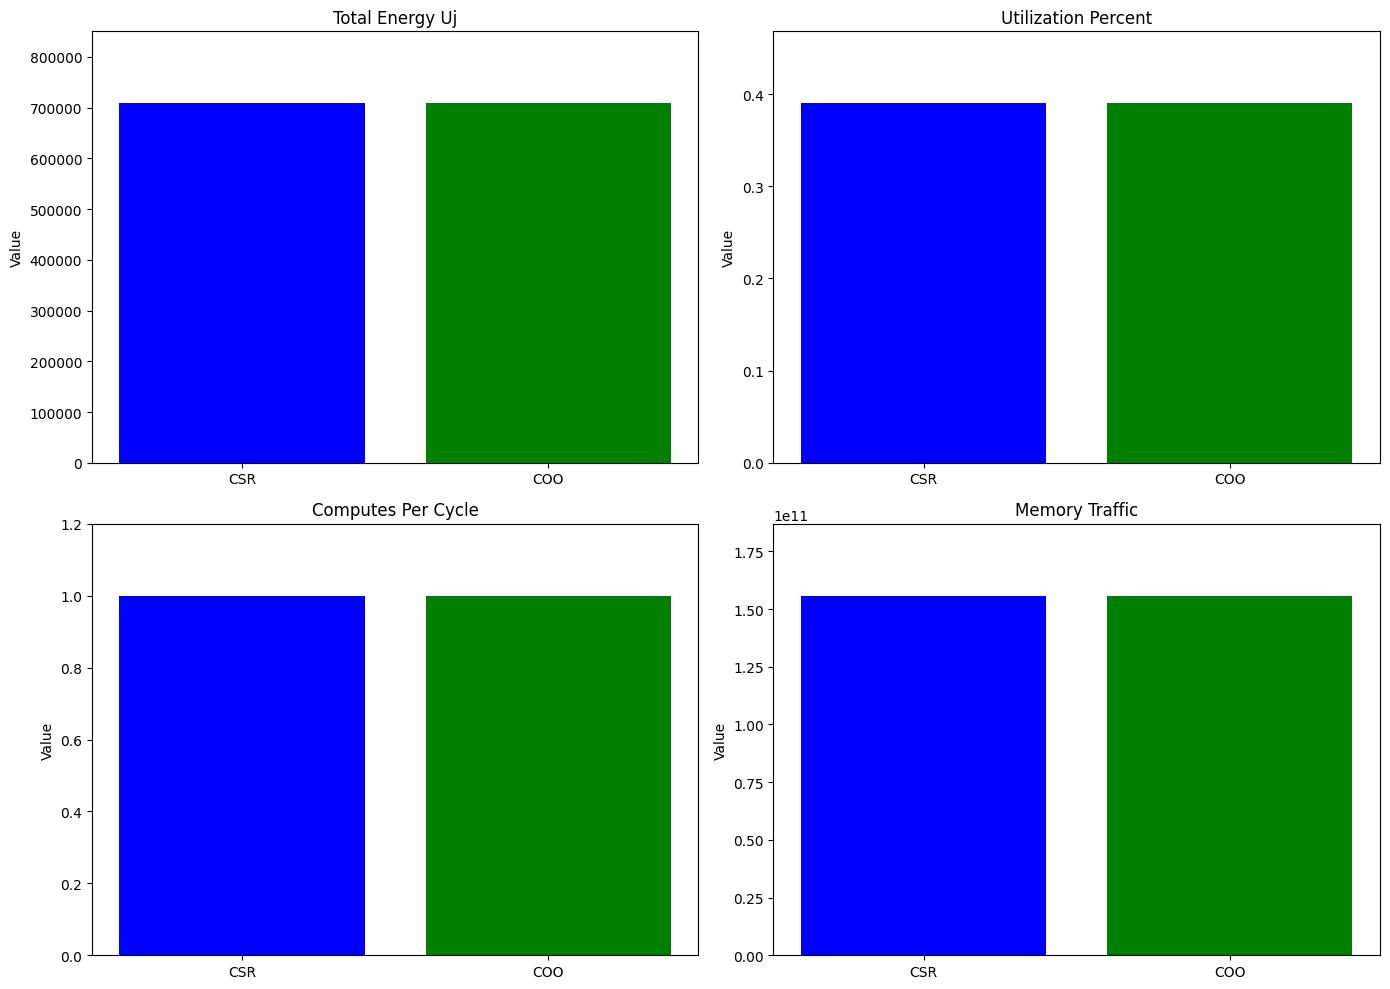

In [50]:
with open(f"{folder}/sparse_opt_data.json", "r") as f:
    loaded_data = json.load(f)
sparse_opt_data = loaded_data

sparsity_opt_data = {
    'CSR': {
        'total_energy_uJ': 1,
        'utilization_percent': 1,
        'computes_per_cycle': 1,
        'memory_traffic': 1
    },
    'COO': {
        'total_energy_uJ': 1,
        'utilization_percent': 1,
        'computes_per_cycle': 1,
        'memory_traffic': 1
    },
}

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, attr in enumerate(attributes):
    csr_val = sparse_opt_data["CSR"].get(attr, 0)
    coo_val = sparse_opt_data["COO"].get(attr, 0)

    axs[i].bar(["CSR", "COO"], [csr_val, coo_val], color=["blue", "green"])
    axs[i].set_title(attr.replace('_', ' ').title())
    axs[i].set_ylabel("Value")
    axs[i].set_ylim(0, max(csr_val, coo_val) * 1.2)  # add headroom

plt.tight_layout()
plt.show()